In [28]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
import gym
import matplotlib
import matplotlib.pyplot as plt
import itertools


env = gym.make("CartPole-v1")

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
class replayBuffer(object):
    def __init__(self, capacity, nStep):
        self.capacity = capacity
        self.nStep = nStep
        self.memory = deque(maxlen=self.capacity)

    def store(self, state,action,reward,done,b_prob,sigma):
        self.memory.append([state,action,reward,done,b_prob,sigma])

    def sample(self, batch_size):
        
        tempBuf = []
        x = random.sample(range(0, len(self.memory) - self.nStep), batch_size)
        
        return x
    def getMemory(self):
        return self.memory

    def __len__(self):
        return len(self.memory)


In [30]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions,epsilonS = 0.1, epsilonE = 0.01, epDecay = 0.98):
        super(DQN, self).__init__()
        self.nA = n_actions
        self.epsilon = 0.5
        self.epsilonE = epsilonE
        self.epDecay = epDecay
        self.count = 1
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
    def action(self,state):  
        
        if self.count % 100 == 0:
            if self.epsilon > self.epsilonE:
                self.epsilon = self.epsilon * self.epDecay
        self.count + 1
        A = np.ones(self.nA, dtype=float) * (self.epsilon/self.nA)
        temp = self.forward(state)
        best_action = temp.max(1)[1].data[0].item()
        A[best_action] += 1.0 - self.epsilon
        return A

In [31]:

def plot_durations(episode,labele,show_result=False):
    
    durations_t = torch.tensor(episode, dtype=torch.float)
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(),label = labele)

In [32]:

def run(batchSize,LR,nStep,update,episode,gamma):
    b_epsilonS = 1
    b_epsilonE = 0.01
    

    
    buffer = replayBuffer(10000,nStep)

    
    experiences = None
    updateCount = 0


    observation_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    actions = list(range(0,env.action_space.n))

    b_net = DQN(observation_dim,action_dim,b_epsilonS,b_epsilonE).to(device)
    pi_net = DQN(observation_dim,action_dim).to(device)
    b_net.load_state_dict(pi_net.state_dict())
    optimizer = torch.optim.Adam(b_net.parameters(), lr=LR)
    
    for ep in range(episode):
        T = np.inf
        t = 0
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        b_prob = b_net.action(state)
        action = np.random.choice(actions,p=b_prob)
        sigma = 0.5
        done = 0
        buffer.store(state,action,0,done,b_prob[action],sigma)
        while t < T:
            next_state,reward,next_done,info = env.step(action)
            state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            done = next_done
            if done:
                T = t + 1
            else:
                b_prob = b_net.action(state)
                action = np.random.choice(actions,p=b_prob)
            buffer.store(state,action,reward,done,b_prob[action],sigma)
            if(len(buffer) > 200):
                experiences = buffer.sample(batchSize)
                memory = buffer.getMemory()
                storedS = []
                storedA = []
                storedG = []
                optimizer.zero_grad()
                for ex in experiences:
                    stateN = memory[ex + nStep][0]
                    actionN = memory[ex + nStep][1]
                    qN = pi_net.forward(stateN).detach().squeeze(0)
                    G = qN[actionN]
                    for k in range((ex+nStep),ex,-1):

                        stateK = memory[k][0]
                        actionK = memory[k][1]
                        rewardK = memory[k][2]
                        done = memory[k][3]
                        b_probK = memory[k][4]
                        sigmaK = memory[k][5]
                        
                        if done:
                            G = reward
                        else:

                            s_k = stateK
                            a_k = actionK
                            r_k = rewardK
                            bProb_k = b_probK
                            sigma = sigmaK

                            pi_prob = pi_net.action(s_k)
                            piProb_k = pi_prob[a_k]
                            pho_k = piProb_k / bProb_k
                            q_k = pi_net.forward(s_k).detach().squeeze(0)

                            VBar = np.sum([(pi_prob[a]) * q_k[a] for a in range(action_dim)])
                            G = r_k + gamma * ((sigma * pho_k) + ((1-sigma) * pi_prob[a_k])) * (G - q_k[a_k])+ gamma * VBar

                    stateL = memory[ex][0].squeeze(0)
                    actionL = torch.tensor([memory[ex][1]], dtype=torch.int64, device=device)
                    storedS.append(stateL)
                    storedA.append(actionL)
                    storedG.append(G)
                storedG = torch.tensor(storedG, dtype=torch.float32, device=device)
                storedS = torch.stack(storedS, dim=0)
                storedA = torch.tensor(storedA, dtype=torch.int64, device=device)

                q_values = b_net.forward(storedS)
                q_value = q_values.gather(1, storedA.unsqueeze(1)).squeeze(1)
                loss = (storedG - q_value).pow(2)
                loss = loss.mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                updateCount = updateCount + 1
                if updateCount % update == 0:
                    pi_net.load_state_dict(b_net.state_dict())

            t=t+1
        episode_durations.append(T)
        print(ep)

    
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Complete
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102

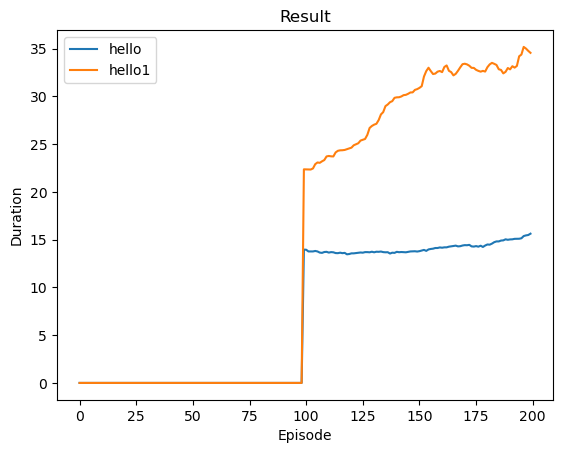

In [33]:
batchSize = 1
LR = 1e-4
update = 50
nStep = 3
episode = 200
gamma = 0.99
plt.figure(1)

plt.title('Result')
plt.xlabel('Episode')
plt.ylabel('Duration')
episode_durations = []
run(batchSize,LR,nStep,update,episode,gamma)

print('Complete')
episode1 = episode_durations
plot_durations(episode1,"hello")
LR = 1e-3
episode_durations = []
run(batchSize,LR,nStep,update,episode,gamma)
print('Complete')
episode2 = episode_durations
plot_durations(episode2,"hello1")

plt.legend()
plt.savefig('results.png')
plt.show()
